## 目次

- 0.はじめに
    - 0-1. コンペ概要
    - 0-2. 特にアドバイスがほしいこと
    - 0-3. (自分が感じた)コンペの特徴
    - 0-4. 生データのカラム
- 1.EDA、前処理
    - 1-1. データの読み込み、結合
    - 1-2. EDA
    - 1-3. 前処理、特徴量エンジニアリング
    - 1-4. ハイパーパラメータチューニング
- A. 最終的に採用したモデル
    - 2-A. モデル構築、学習
    - 2-1-Aモデル評価
    - 3-A. 学習したモデルで予測
- B. 没になったモデル１(sub model)
    - 2-B. モデル構築、学習
    - 3-B. 学習したモデルで予測
- C. 没になったモデル２(stacking)
    - 2-C. モデル構築、学習
    - 3-C. 学習したモデルで予測

# 0. はじめに
<b>ぜひアドバイスをください！分析手法、コーディング手法、戦略、テクニック、心構え、このノートブックの書き方、その他細かい部分などなど・・・あらゆる面のアドバイス大大大歓迎です！！自分の理解にもつながるので、ご質問も歓迎です！（答えられる範囲で）</b><br>

※自分用の備忘録も兼ねているため長いです。<br><b>適当に読み飛ばしてください!!</b>

## 0-1. コンペ概要

### 課題：高速道路の渋滞予測
コンペ説明ページ：https://signate.jp/competitions/932<br>
説明会動画：https://youtu.be/GPPwGKVNxP0

Signateで2023年3月31日で応募を締め切ったコンペです。<br>
初参加で銀メダルをとった記念すべきコンペで、結果はそれなりに見てくれがよいかもしれませんが、内容としては「よくわからんけどなんか結果出た。知らんけど」感が否めないです。ちなみに最も苦戦したのは分析面ではなく、~初心者同士でチームを組んだけどメンバーが失踪して結局孤独な闘いだったこと~「環境構築」と「エラーを出さずにsubmitする」といったエンジニアリング面でした。

<b>[概要]</b><br>
<b>時系列データを扱い、INPUTデータの翌日の高速道路（関越道・館山道）の渋滞の有無(0 or 1)を予測する二値分類問題です。評価指標はf1スコア</b><br>
正確には、翌日の１時間ごとの渋滞の有無を、高速道路の区間ごとに予測します。<br>
ex)<br>
INPUT : 2021/4/1 00:00 ~ 2022/07/31 23:00までの区間A～Eのデータ<br>
OUTPUT : 2022/08/01 00:00~23:00の区間A～Eの渋滞を予測

<b>[結果]</b><br>
29/684位でf1スコア0.697（計算時間0.421s）<br>1位は0.757(計算時間0.413s)です。計算時間は同等(2位に関しては0.169s)なので、特徴量エンジニアリングで差が出たのか、不均衡データにうまく対応しているのか、使っているアルゴリズムが違うのか（僕はLightGBMです）、パラメータチューニングなどの細かい積み重ねなのか・・・

## 0-2. 特にアドバイスがほしいこと

- ハイパーパラメータのチューニングの計算リソースが足りずにデータ量を100分の1にランダムサンプリングしてチューニングしたんですが、これって不味いやり方なんでしょうか・・・？そんなに高性能なPCを持っているわけでもなく、GoogleColabを使ってみましたが12hタイムアウトするくらい計算時間がかかりました。やり方が間違っている？
- オーバーサンプリング、アンダーサンプリング、SMOTEなどのデータ量を増減させる塩梅も、ハイパーパラメータとしてチューニングするものなんでしょうか？
- 今回のコンペでは、すべてのデータを学習させたひとつのモデルではなく、KFoldでFoldごとに分割したデータを学習させた複数のモデルでアンサンブルした方がスコアが高かったです。ということで以下の推察をしているんですが、考え方は合っていますか？
    - 分布の傾向がはっきりするほどデータ量が十分にあるデータであればそもそもbiasが小さくなりやすいので、varianceを下げることを優先してすべてのデータを学習させたひとつのモデルの方がよい傾向がある
    - 分布の傾向がはっきりしないくらいデータ量が少ないデータの場合はbiasが大きくなりやすいので、biasを下げることを優先してデータを分割して複数のモデルでアンサンブルしたモデルの方がよい傾向がある　※今回はこれ。特に極端な不均衡データなので、正解ラベルのデータ数は少なく、かつ最終テストするデータもランダムサンプリングされたデータではなく、連続した数か月間なので、学習データの分布と比較して偏りがある可能性大。

## 0-3. (自分が感じた)コンペの特徴

- おそらく主催者側のアイデアとして、「ドラぷら」という高速道路のルート検索システム（Google mapによる乗り換え検索の高速道路版のイメージ）へのアクセスデータが増えた数日後に、実際にその高速道路の交通量が増えるはず、という発想があったのだと思います。そのデータを特徴量として使えます。
- 一般的なことかもしれませんが、計算時間の制限があります。限られた計算リソースで高精度をたたき出す必要があります。
- １年間の全期間、高速道路の全区間という広い視野で見ると渋滞することは稀な現象なので、かなりの<b>不均衡データです（EDA参照）。</b>
- 学習データはコロナ禍真っ只中の2021年4月8日～2022年7月31日、最終的なテストデータはやや緩和された2022年8月1日～2022年9月30日, 2023年4月1日～2023年5月7日
- コンペにおける渋滞の定義が「車の平均速度が時速40km以下」です。一方で、扱うデータが「１台も車が通過しない場合は平均速度を0とする」という処理をしているため、<b>１台も通過していないのに渋滞と判定されているデータがそこそこあります（EDA参照）。</b>これは前処理で何とかできる可能性がある部分と、なんともならない部分があると思っています。精度100%を目指すのであれば「1台も通過していないけど渋滞と予測」しなければならないですが、それを追いすぎると性能は悪化してしまう気がします。（この辺、開拓の余地が大いにあった気がしますが、エンジニアリング面で時間がとられてあまり手が出せませんでした）

## 0-4. 生データのカラム
（明らかに不必要だと判断したものは削っています）

|カラム名|データ型|内容|例|
|----|----|----|----|
|datetime|str|日時|2021-04-08 00:00:00|
|start_code|int|高速道路の区間の始点コード|1800006|
|end_code|int|高速道路の区間の終点コード|1110210|
|allCars|int|1時間内の全車線の通過台数の合計|568|
|OCC|float|1時間内の全車線の占有率(%)|1.6|
|speed|float|1時間内の全車線の平均速度|87|
|is_congestion|int|渋滞あり・なし(目的変数)|0 or 1|
|search_1h|int|1時間ごとに集計したドラぷらルート検索データ(時間指定あり検索数)|4|
|search_unspec_1d|int|前日分として集計したドラぷらルート検索データ(時間指定なし検索数)|4|
|start_lat|float|区間の始点ICの緯度|35.80615|
|end_lat|float|区間の終点ICの緯度|35.75582|
|start_lng|float|区間の始点ICの経度|139.535511|
|end_lng|float|区間の終点ICの経度|139.601514|
|start_degree|int|区間の始点ICが接続する他ICの数|2|
|end_degree|int|区間の終点ICが接続する他ICの数|4|
|direction|str|方向|上り|
|limit_speed|int|区間の制限速度(km/h)|100|
|road_code|int|道路コード(関越道:1800, 館山道:1130)|1800|

<b>[心がけたこと]</b>
- datetimeの時系列データなので、月、週、時間などの周期性を反映できるような特徴量をつくる
    - 月をsin/cos変換したmonth_cos, month_sinなど 　　参考：https://qiita.com/shimopino/items/4ef78aa589e43f315113<br> → 今回はそこまで利きませんでした
- 周期性とは関係のない、コロナ禍という長期的なトレンドがあるため、これを反映できる特徴量をつくる
    - 経過日数を表す特徴量time_delta → 結構効きました
- ラグ特徴量をつくる
    - その日の渋滞有無を表す特徴量is_congestionを１日分ずらして、次の日の渋滞有無を表す特徴量will_be_congestionを作り、これを目的変数とする。<br>→ これが一番効きました。「翌日の渋滞有無」を予測するコンペなので気付けたら当たり前ですが、フォーラムで公開されているベースラインはis_congestionを目的変数としていました。この類の処理をやるかどうかがメダルとそれ以外を分けたんじゃなかろうかと勝手に思っています。
    - 数日前までのルート検索システムの検索数の合計5day_search_sumなど<br>→「検索数増加の数日後に交通量が増える」のイメージで特徴量を作りましたが、あまり利きませんでした。今思えば、「数日前」ではなく「数時間前」のデータを使った方がよいのかもしれなかったです。ルート検索って数日前に計画的にやるよりも、移動の直前にやる方がおそらく多いですよね。<br><b>ちなみにコードの書き方はChatGPTを大いに参考にしました。</b>恐ろしい性能ですが、アウトプットされたコードがコピペでそのまま動くことはほとんどなく、「適切に指示するスキル」「アウトプットを検証するスキル」が重要だと感じました。めちゃくちゃ博識で仕事も速いけど、ちょっと融通が利かなくて平然とミスもして平気で嘘もつく部下って感じです。この部下をうまくマネジメントするスキルが今後重要になってくるんでしょうね。
- 不均衡データに対処する
    - StratifiedGroupKFoldで交差検証する※Groupは日にちを表す特徴量date <br> →他のCV手法も試しましたが、これが一番よかったです。ただしフォーラムで公開されたコードが採用していたので、他の参加者とは差がつけられなかったと思います。初めて使う手法でしたが勉強になりました。時系列だからTimeSeriesSplitってわけではないんですね。
    - オーバーサンプリング、アンダーサンプリング、SMOTE<br>→ SMOTEだけやりましたが汎化性能悪化しました。たぶんデータを増やしすぎて過学習したんだと思います・・・データを増やす量をコントロールすればよかったのかもしれませんが、はじめて使うこともあり、時間切れで検証出来ずでした。<b>この辺のデータ量を増減させる塩梅もハイパーパラメータとしてチューニングするものなんでしょうか？</b>ちなみにオーバーサンプリング、アンダーサンプリングも検証出来ずでした。

# 1. EDA、前処理

## 1-1. データの読み込み、結合

生データroad.csv, search_data.csv, search_unspec_data.csv, train.csvを読み込み、コンペのルールに合わせて結合して、input_dfを生成

In [1]:
import datetime as dt
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import lightgbm as lgb
import sys

In [1]:
# 生データの結合をする関数。結合のkeyはdatetimeや高速道路の区間を表すsection
def pre_extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    train_df['date'] = train_df['datetime'].dt.date
    train_df['datetime'] = train_df['datetime'].astype(str)
    train_df['date'] = train_df['date'].astype(str)
    
    train_df = train_df.merge(road_df, on=['start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['date', 'start_code', 'end_code'], how='left')
    train_df.sort_values(['date', 'start_code', 'end_code'], inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    train_df.drop(columns=['date'], inplace=True)
    train_df.dropna(axis=0, inplace=True) #search_spec_df、search_unspec_dfで1日分ずらす（下のセル参照）ため、端っこの1日分はNaNになる -> 除外
    
    return train_df

In [3]:
# 生データの読み込み -> 結合してinput_dfの作成
road_df = pd.read_csv('../../train/road.csv')
search_spec_df = pd.read_csv('../../train/search_data.csv')
search_unspec_df = pd.read_csv('../../train/search_unspec_data.csv')
train_df = pd.read_csv('../../train/train.csv')

# コンペのルール上、検索数は当日のデータを使えるので、search_spec_dfとsearch_unspec_dfは一日前にずらす
# ex)3/10のis_congestionを予測する際には、基本的には3/9のデータを使う。(3/10は使えない)
#    ただし検索数は3/10のものを使ってOK -> 1日前にずらしてからtrain_dfと結合
## datetimeやdateをdatetime型にしたりstr型にしたりと行ったり来たりしているのは、
## datetime型じゃないとできない操作、str型じゃないとできない操作があるため（もっとスマートな方法があればアドバイスください！）
search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])
search_spec_df['datetime'] -= pd.to_timedelta(1, 'd')
search_unspec_df['date'] -= pd.to_timedelta(1, 'd')
search_spec_df['datetime'] = search_spec_df['datetime'].astype('str')
search_unspec_df['date'] = search_unspec_df['date'].astype('str')

# 結合
input_df = pre_extract_dataset(train_df, search_spec_df, search_unspec_df)

## 1-2. EDA

### 1-2-1. 渋滞有無の比率の確認

In [ ]:
#is_congestion==0/is_congestion==1の比率の確認
isnt_congestion_num = len(input_df[input_df["is_congestion"]==0])
is_congestion_num = len(input_df[input_df["is_congestion"]==1])

print("渋滞していないデータ数：", isnt_congestion_num)
print("渋滞しているデータ数：", is_congestion_num)
print("渋滞しているデータ数/全データ数=", is_congestion_num/len(input_df))

渋滞していないデータ数： 906031
渋滞しているデータ数： 3054
渋滞しているデータ数/全データ数= 0.0033594218362419355


### 1-2-2. 渋滞有無(is_congestion)とsearch(検索システムの検索数)の時間別のカウント数

is_congestionとsearchの時間に対する傾向を見てみると、
- hourに対してis_congestionとsearchに特徴的な周期性がある。is_congestionは単純に人の移動が多い時間に渋滞が起きやすく、searchは人の生活リズムが反映されている。
- dayに対しては、is_congestionとsearchどちらも基本的にはほぼ一定。(31日が減っているのは、月によって31日があったりなかったりするからだと思う)。少し気になるのは、3～5日あたりに特徴的な形状がある。大型連休は3~5日あたりが多いので、それが反映されている？つまり、dayとの因果関係はない偽相関
- monthに対するsearchの変化を見ると、年度初めの検索数が多いように思える。新生活のため？is_congestionは傾向があるか微妙
- dayofweekは重要っぽい。平日に検索して、土日に移動、というパターンが多い？であれば、大体２～５日前の検索数が渋滞の起きやすさに影響している、という仮説が立つ → 休日か否かを判定するフラグを特徴量にする

In [11]:
#hour, day, month, dayofweek別のis_congestionの傾向を調査するためのDataFrameを生成
hour_is_congestion_pivot = train.pivot_table(values="KP", columns="is_congestion", index="hour", aggfunc=len)
day_is_congestion_pivot = train.pivot_table(values="KP", columns="is_congestion", index="day", aggfunc=len)
month_is_congestion_pivot = train.pivot_table(values="KP", columns="is_congestion", index="month", aggfunc=len)
# year_is_congestion_pivot = train.pivot_table(values="KP", columns="is_congestion", index="year", aggfunc=len) #yearは2021と2022の２つしかないので割愛
dayofweek_is_congestion_pivot = train.pivot_table(values="KP", columns="is_congestion", index="dayofweek", aggfunc=len)

#hour, day, month, dayofweek別のsearch_1hの傾向を調査するためのDataFrameを生成
hour_search_1h_pivot = train.pivot_table(values="KP", columns="search_1h", index="hour", aggfunc=len)
day_search_1h_pivot = train.pivot_table(values="KP", columns="search_1h", index="day", aggfunc=len)
month_search_1h_pivot = train.pivot_table(values="KP", columns="search_1h", index="month", aggfunc=len)
# year_search_1h_pivot = train.pivot_table(values="KP", columns="search_1h", index="year", aggfunc=len) #yearは2021と2022の２つしかないので割愛
dayofweek_search_1h_pivot = train.pivot_table(values="KP", columns="search_1h", index="dayofweek", aggfunc=len)

Text(0, 0.5, 'is_congection==1')

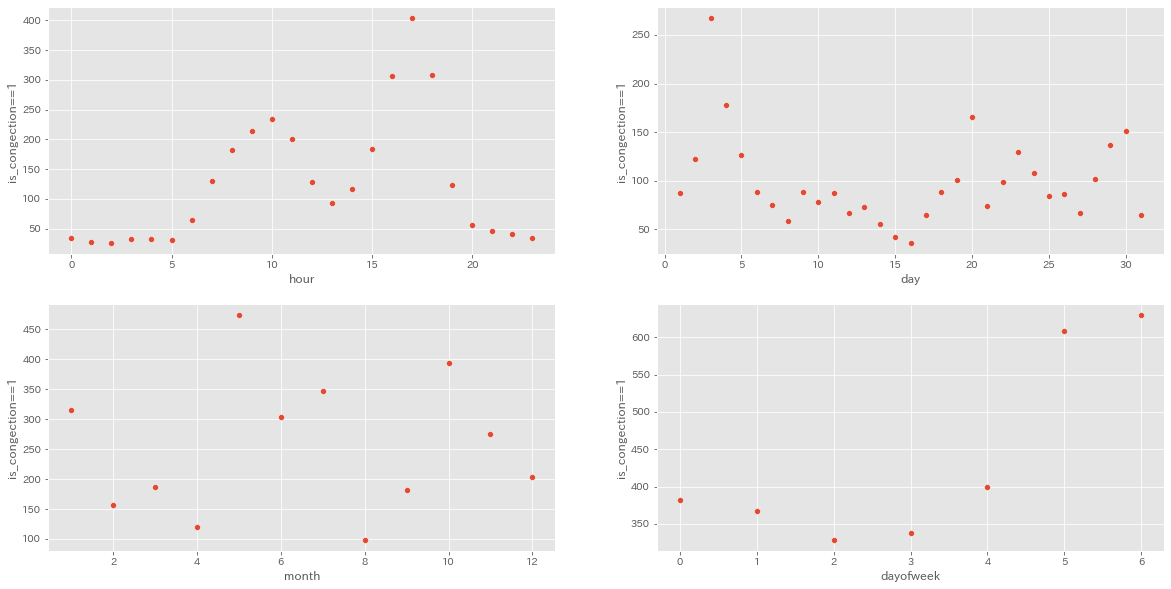

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=hour_is_congestion_pivot[1], ax=ax.ravel()[0])
sns.scatterplot(data=day_is_congestion_pivot[1], ax=ax.ravel()[1])
sns.scatterplot(data=month_is_congestion_pivot[1], ax=ax.ravel()[2])
# sns.scatterplot(data=year_is_congestion_pivot[1], ax=ax.ravel()[3])
sns.scatterplot(data=dayofweek_is_congestion_pivot[1], ax=ax.ravel()[3])
ax.ravel()[0].set_ylabel("is_congection==1")
ax.ravel()[1].set_ylabel("is_congection==1")
ax.ravel()[2].set_ylabel("is_congection==1")
ax.ravel()[3].set_ylabel("is_congection==1")
# ax.ravel()[4].set_ylabel("is_congection==1")

Text(0, 0.5, 'search')

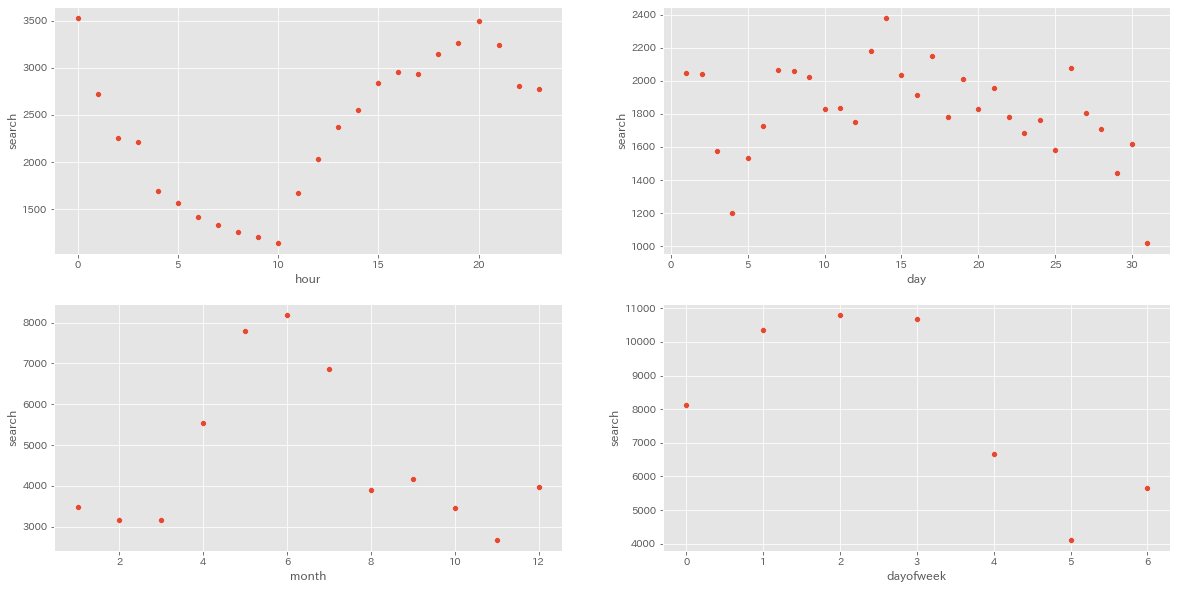

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=hour_search_1h_pivot[1], ax=ax.ravel()[0])
sns.scatterplot(data=day_search_1h_pivot[1], ax=ax.ravel()[1])
sns.scatterplot(data=month_search_1h_pivot[1], ax=ax.ravel()[2])
# sns.scatterplot(data=year_search_1h_pivot[1], ax=ax.ravel()[3])
sns.scatterplot(data=dayofweek_search_1h_pivot[1], ax=ax.ravel()[3])
ax.ravel()[0].set_ylabel("search")
ax.ravel()[1].set_ylabel("search")
ax.ravel()[2].set_ylabel("search")
ax.ravel()[3].set_ylabel("search")
# ax.ravel()[4].set_ylabel("search")

### 1-2-3. speed, allCars, OCCの分布

渋滞（is_congestion == 1）の時のデータについて、speed(通過車両の平均速度)、allCars(通行量)、OCC(speedとallCardsによって算出されるパラメータ)の分布をそれぞれ見てみると、0近辺にスパイク的な分布がある。<b>なんか変なことが起きている可能性が高い</b><br>→ コンペにおける渋滞の定義が「車の平均速度が時速40km以下」。一方で、扱うデータが「１台も車が通過しない場合は平均速度を0とする」という処理をしているため、<b>１台も通過していないのに渋滞と判定されているデータがそこそこある</b>ようです

Text(0.5, 1.0, 'is_congestion==1')

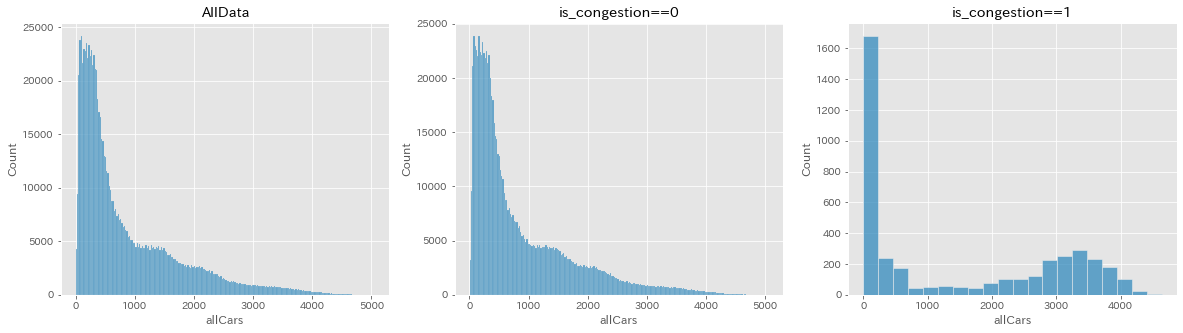

In [ ]:
#allCarsの分布。AllData/is_congestion==0/is_congestion==1
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(input_df["allCars"], ax=axes.ravel()[0])
sns.histplot(input_df[input_df["is_congestion"]==0]["allCars"], ax=axes.ravel()[1])
sns.histplot(input_df[input_df["is_congestion"]==1]["allCars"], ax=axes.ravel()[2], bins=20)
axes[0].set_title("AllData")
axes[1].set_title("is_congestion==0")
axes[2].set_title("is_congestion==1")

Text(0.5, 1.0, 'is_congestion==1')

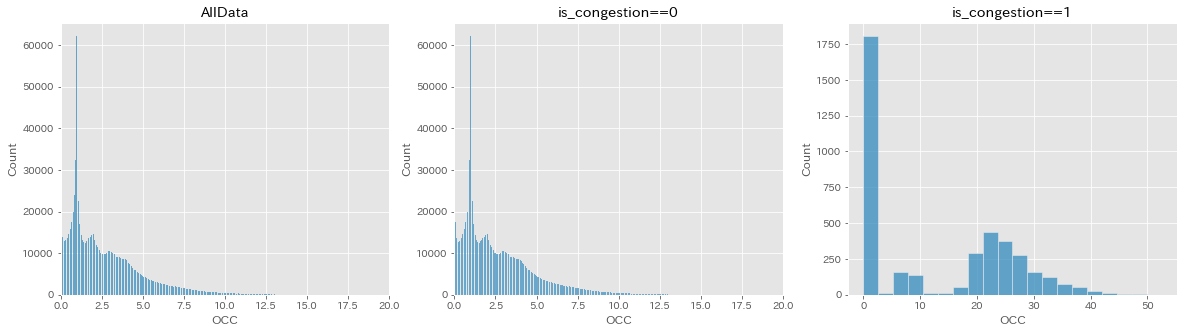

In [ ]:
#OCCの分布。AllData/is_congestion==0/is_congestion==1
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(train_df["OCC"], ax=axes.ravel()[0])
sns.histplot(train_df[train_df["is_congestion"]==0]["OCC"], ax=axes.ravel()[1])
sns.histplot(train_df[train_df["is_congestion"]==1]["OCC"], ax=axes.ravel()[2], bins=20)
axes[0].set_title("AllData")
axes[0].set_xlim(0, 20)
axes[1].set_title("is_congestion==0")
axes[1].set_xlim(0, 20)
axes[2].set_title("is_congestion==1")

Text(0.5, 1.0, 'is_congestion==1')

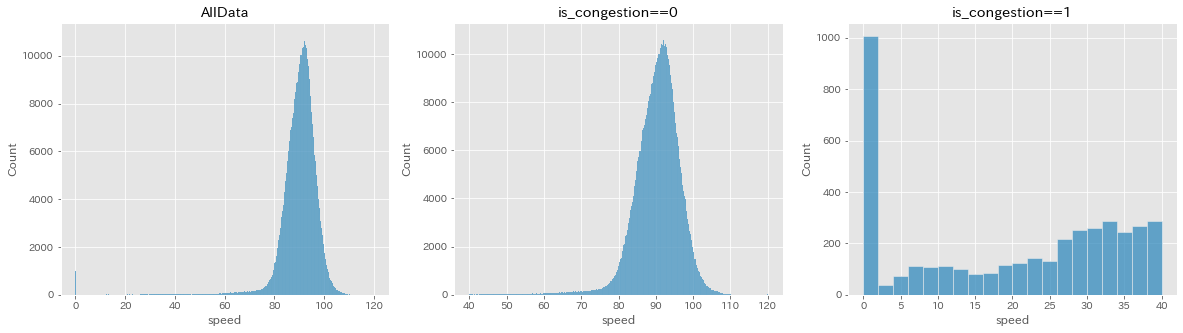

In [ ]:
#speedの分布。AllData/is_congestion==0/is_congestion==1
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(train_df["speed"], ax=axes.ravel()[0])
sns.histplot(train_df[train_df["is_congestion"]==0]["speed"], ax=axes.ravel()[1])
sns.histplot(train_df[train_df["is_congestion"]==1]["speed"], ax=axes.ravel()[2], bins=20)
axes[0].set_title("AllData")
# axes[0].set_xlim(0, 20)
axes[1].set_title("is_congestion==0")
# axes[1].set_xlim(0, 20)
axes[2].set_title("is_congestion==1")

## 1-3. 前処理、特徴量エンジニアリング

In [3]:
# 時系列データをsin/cos変換する関数。
## 例えば4/29 → 4/30 → 5/1 → 5/2はそれぞれ一日の差しかないが、特徴量として扱う際、
## 29→30や1→2は数値として1の差なのに対して、30→1は-29の差となってしまい、おかしなバイアスがかかってしまう。
## これに対してsinとcosの周期性をうまく使って対応する。
## ※イメージとして、sin(358°), sin(359°), sin(0°), sin(1°)の差はそれぞれ等しい
## 参考：https://qiita.com/shimopino/items/4ef78aa589e43f315113
def encode(df, col):
    # この方法だと最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [5]:
# datetimeのみに依存する特徴量の特徴量エンジニアリング（date_df）

## 休日かどうか、などのdatetimeのみに依存する特徴量はINPUTデータに依存しないので、INPUTデータと独立して作成(date_df)し、後で結合。（他のコンペで再利用できます）
## 大型連休 → 渋滞多い　という発想から、その日が3連休以上なのか否かを判定するフラグを生成　※これは利かなかったので削除しました
## また、大型連休の真ん中よりも初日と最終日が混みそうなので、それも判定　※これだけ残しました

## 年月日が入った列'datetime'を生成
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2023, 12, 31)
date_range = pd.date_range(start_date, end_date, freq='D')
date_df = pd.DataFrame({'date': date_range})

##'datetime'が休日かどうかを判定し、休日であれば1、休日でなければ0の値をとる列'is_holiday'を生成
date_df['is_holiday'] = date_df['date'].apply(lambda x: 1 if (x.weekday() >= 5 or jpholiday.is_holiday(x)) else 0)

## 3連休以上のときの初日なら１をとる列を生成
date_df['is_start_of_long_holiday'] = 0
long_holiday = 0
for i in range(len(date_df)):
    if date_df.loc[i, 'is_holiday'] == 1:
        long_holiday += 1
        if long_holiday >= 3:
            date_df.loc[i - long_holiday + 1, 'is_start_of_long_holiday'] = 1
    else:
        long_holiday = 0

## 3連休以上のときの最終日なら１をとる列を生成
date_df['is_end_of_long_holiday'] = 0
long_holiday = 0
for i in range(len(date_df)-1, -1, -1):
    if date_df.loc[i, 'is_holiday'] == 1:
        long_holiday += 1
        if long_holiday >= 3:
            date_df.loc[i + long_holiday - 1, 'is_end_of_long_holiday'] = 1
    else:
        long_holiday = 0

## datetimeを分解して、年・月・日・時や曜日、経過日数などを生成
date_df['year'] = date_df['date'].dt.year
date_df['month'] = date_df['date'].dt.month
date_df['day'] = date_df['date'].dt.day
date_df['dayofweek'] = date_df['date'].dt.weekday
date_df = encode(date_df, 'month')
date_df = encode(date_df, 'day')
date_df = encode(date_df, 'dayofweek')
date_df['date'] = date_df['date'].astype(str)

In [ ]:
# INPUTデータに対する特徴量エンジニアリング

## 不要なカラムの削除
### start_name, end_nameはstart_code, end_codeと完全な一対一対応をしているので、不要。
### 残してしまうと多重共線性の問題が起こりますね。
input_df.drop(columns=['start_name', 'end_name'], inplace=True)

## datetimeを分解して、年・月・日・時や曜日、経過日数などを生成
input_df['datetime'] = pd.to_datetime(input_df['datetime'])
input_df['date'] = input_df['datetime'].dt.date
input_df['hour'] = input_df['datetime'].dt.hour
input_df['timedelta'] = (input_df['datetime'].dt.date - input_df['datetime'].dt.date.iloc[0]).dt.days
input_df['datetime'] = input_df['datetime'].astype(str)
input_df['date'] = input_df['date'].astype(str)

## 高速道路の区間の始点と終点から、始点～終点を示すカテゴリ変数sectionを生成
input_df['section'] = input_df['start_code'].astype(str)+'_' + input_df['end_code'].astype(str)

## 次の処理の関係で、デフォルトでは'section'が第一キー、'date'が第二キーでソートしてあるが、入れ替える
### 試行錯誤した結果、これでうまくいきました。
input_df = input_df.sort_values(['section', 'date'])

## 5日前までの検索数を集計
### 2日前～7日前で試した結果、5日前が一番効きました。でも「数時間前」も試してもよかったかも。
search_window_days = 5
search_window_df = input_df[['date', 'section', 'search_unspec_1d']]
search_window_df.drop_duplicates(inplace=True)
search_window_df.reset_index(drop=True, inplace=True)

## 各section毎に周辺5日間のアクセス数の合計値を追加
### この処理にfor文を使うと計算時間が膨大になったので、コーディングに苦労したところ。(そんなに利きませんでしたが・・・)
search_window_df[f'{search_window_days}day_search_sum'] = search_window_df.groupby('section')['search_unspec_1d'].rolling(window=search_window_days, center=False, min_periods=search_window_days).sum().reset_index(drop=True)
search_window_df[f'{search_window_days}day_search_sum'] = search_window_df.groupby('section')[f'{search_window_days}day_search_sum'].fillna(method='ffill').fillna(method='bfill')
search_window_df.drop(columns=['search_unspec_1d'], inplace=True)

## 検索数、日付の特徴量をマージ
input_df = input_df.merge(search_window_df, on=['date', 'section'])
input_df = input_df.merge(date_df, on=['date'])
input_df = encode(input_df, 'hour')

# 目的変数の生成
# 予測したい目的変数は、当日のis_congestionではなく、翌日のis_congestion -> will_be_congestion
# searchと同じ要領で、一日ずらしてから結合する
y_temp = input_df[['datetime', 'section', 'is_congestion', 'speed']]
y_temp['datetime'] = pd.to_datetime(y_temp['datetime'])
y_temp['datetime'] -= pd.to_timedelta(1, 'd')
y_temp['datetime'] = y_temp['datetime'].astype(str)
y_temp.rename(columns={'is_congestion':'will_be_congestion',
                       'speed':'tomorrow_speed'}, inplace=True)
input_df = input_df.merge(y_temp, on=['datetime', 'section'], how='outer')

input_df.dropna(inplace=True)

In [ ]:
# 予測に使用する特徴量を量的変数、カテゴリ変数に分けて抜粋
## まずはすべての特徴量を羅列してから、特徴量選択して、コメントアウトで削減していきました。
## 特徴量選択の根拠はモデルの重要度です。（他の手法も試したかったですが、時間切れです）

target_col = 'will_be_congestion'
#sub_target_col = 'tomorrow_speed' #サブモデルを作った時の残骸
cate_cols = [
             # 'start_code',
             # 'end_code',
             # 'start_pref_code',
             # 'end_pref_code',
             # 'limit_speed',
             # 'road_code',
             'direction',
             'is_holiday',
             'section',
             'is_start_of_long_holiday',
             'is_end_of_long_holiday',
             # 'long_holiday_with_1day_paid_day_off',
             # 'is_start_of_long_holiday_with_1day',
             # 'is_end_of_long_holiday_with_1day',
             # 'long_holiday_with_2day_paid_day_off',
             # 'is_start_of_long_holiday_with_2day',
             # 'is_end_of_long_holiday_with_2day',
            ]
num_cols = ['OCC',
            'allCars',
            'speed',
            # 'start_lat',
            # 'end_lat',
            'start_lng',
            'end_lng',
            # 'start_degree',
            # 'end_degree',
            # 'KP',
            # 'start_KP',
            # 'end_KP',
            'search_1h',
            'search_unspec_1d',
            'timedelta',
            f'{search_window_days}day_search_sum',
            'month_cos',
            'month_sin',
            'day_cos',
            'day_sin',
            'hour_cos',
            'hour_sin',
            'dayofweek_cos',
            'dayofweek_sin']
feature_cols = cate_cols + num_cols

# 目的変数 y、特徴量 Xの分離
y = input_df[target_col]
# y_sub = input_df[sub_target_col] #サブモデルを作った時の残骸
X = input_df[feature_cols]

# 質的変数をLabel-encoding
## ※ツリー系のアルゴリズム以外を使う場合はLabel-encodingはあまりよくない。One-Hot-encodingなどを検討する
le_dict = {}
for cate_col in cate_cols:
    le = LabelEncoder()
    X[cate_col] = le.fit_transform(X[cate_col])
    le_dict[cate_col] = le

# 学習したモデルをsubmitしてテストデータに対して予測する際、
# モデルを学習した時の通りにラベル付けしないとだめなので、対応関係を保存
## 当然ですが、これをやらないとかなり性能悪化します。
with open("../src/features/le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

## 1-4. ハイパーパラメータチューニング
ハイパーパラメータのチューニングの計算リソースが足りずにデータ量を100分の1にランダムサンプリングしてチューニングしたんですが、これって不味いやり方なんでしょうか・・・？そんなに高性能なPCを持っているわけでもなく、GoogleColabを使ってみましたが12hタイムアウトするくらい計算時間がかかりました。やり方が間違っている？

In [ ]:
# optunaによるLightGBMのパラメータチューニング
def objective(trial):
    # ハイパーパラメータの定義

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 20, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'n_estimators': 100000,
        'learning_rate': 0.01,
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'random_state': 0,
    }

    # クロスバリデーションの定義
    k = 5
    cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=0)

    # クロスバリデーションによる評価指標の算出
    f1_scores = []
    X_new, _, y_new, _, input_df_new, _ = train_test_split(X, y, input_df, test_size=0.99)

    for train_idx, val_idx in cv.split(X_new, y_new, groups=input_df_new['date']):
        X_train, y_train = X_new.iloc[train_idx], y_new.iloc[train_idx]
        X_val, y_val = X_new.iloc[val_idx], y_new.iloc[val_idx]
        eval_set = [(X_val, y_val)]
        callbacks = []
        callbacks.append(lgb.early_stopping(stopping_rounds=100))
        callbacks.append(lgb.log_evaluation())
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
        y_pred = model.predict(X_val)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        f1_scores.append(f1_score(y_val, y_pred))     

    return np.mean(f1_scores)
  
# Optunaの最適化実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 結果の出力
print('Best trial:')
trial = study.best_trial
print(f'  f1: {trial.value:.3f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value:.3f}')

## A. 最終的に採用したモデル
ゴリゴリに50foldまでデータを分割して50モデルをアンサンブルしました。5→20→50とデータを分割してモデルを増やすほど性能が向上していきました。計算時間制限ギリギリまでモデルを増やしたかったですが、最終日のsubmit数の上限に達して50までしかやっていません。（ゴリ押しは最後の手段にとっておいたので・・・）<br>サチり気味でしたが、もうちょい精度向上する可能性はありました。<br>

[結果]<br>
50モデル f1 : 0.697　計算時間 : 0.421s<br>
20モデル f1 : 0.691　計算時間 : 0.220s<br>
5モデル　f1 : 0.689　計算時間 : 0.185s<br>

### 2-A. モデル構築、学習

In [7]:
# モデルのパラメータ
main_params = {
    "objective": "binary",
    "n_estimators": 100000,
    "learning_rate": 0.05,
    'max_depth': 15,
    'min_child_samples': 80,
    'num_leaves': 100,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}

# CVの設定
k = 50
cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=0)

# StratifiedGroupKFoldで分割
main_model = lgb.LGBMClassifier(**main_params)
fold_results = []
f1_stack = []
auc_stack = []
for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups=input_df['date'])):
    
    # foldのメッセージ
    print(f'Fold {fold_idx + 1}')
    
    # 学習データと検証データの分割
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # モデルの学習と予測
    eval_set = [(X_valid, y_valid)]
    callbacks = []
    callbacks.append(lgb.early_stopping(stopping_rounds=100))
    callbacks.append(lgb.log_evaluation())
    main_model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
    y_pred_valid = main_model.predict(X_valid)
    
    # 検証データの評価
    f1 = f1_score(y_valid, y_pred_valid)
    auc = roc_auc_score(y_valid, y_pred_valid)
    f1_stack.append(f1)
    auc_stack.append(auc)
    print(f'Validation f1 {fold_idx}fold: {f1:.4f}')
    print(f'Validation auc {fold_idx}fold: {auc:.4f}')

    # モデルの保存
    with open(f"../model/main_lgbm_fold{fold_idx}.pkl", mode="wb") as f:
        pickle.dump(main_model, f)
        
    # 各foldの結果をリストに追加する
    pred_df = pd.DataFrame(y_pred_valid, index=valid_idx)
    fold_results.append(pred_df)
print('f1:', f1_stack)
print('f1 average:', np.mean(f1_stack))
print('auc:', auc_stack)
print('auc average:', np.mean(auc_stack))

Fold 1
[1]	valid_0's binary_logloss: 0.0142502
Training until validation scores don't improve for 1 rounds
[2]	valid_0's binary_logloss: 0.0141021
[3]	valid_0's binary_logloss: 0.0139944
[4]	valid_0's binary_logloss: 0.0138476
[5]	valid_0's binary_logloss: 0.0137097
[6]	valid_0's binary_logloss: 0.013579
[7]	valid_0's binary_logloss: 0.0134503
[8]	valid_0's binary_logloss: 0.0133423
[9]	valid_0's binary_logloss: 0.0132444
[10]	valid_0's binary_logloss: 0.0131262
[11]	valid_0's binary_logloss: 0.0130222
[12]	valid_0's binary_logloss: 0.0129362
[13]	valid_0's binary_logloss: 0.0126822
[14]	valid_0's binary_logloss: 0.0125354
[15]	valid_0's binary_logloss: 0.0123881
[16]	valid_0's binary_logloss: 0.0122605
[17]	valid_0's binary_logloss: 0.012178
[18]	valid_0's binary_logloss: 0.0121042
[19]	valid_0's binary_logloss: 0.0120387
[20]	valid_0's binary_logloss: 0.0119524
[21]	valid_0's binary_logloss: 0.0118946
[22]	valid_0's binary_logloss: 0.0118406
[23]	valid_0's binary_logloss: 0.011758
[2

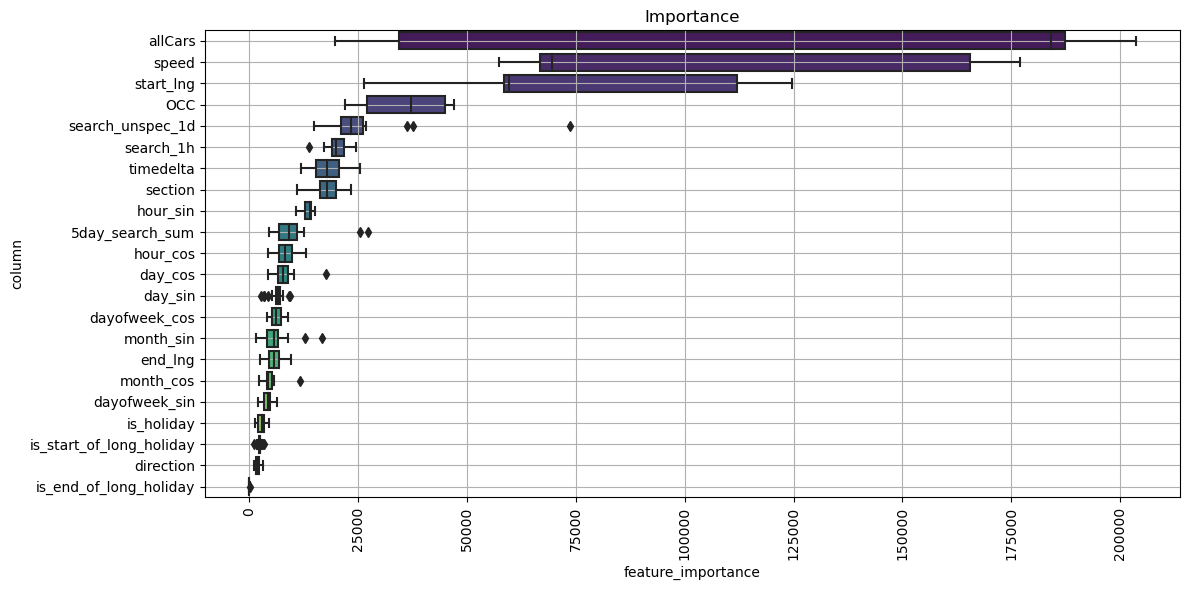

In [8]:
# 特徴量の重要度
## フォーラムで公開されていたコードをほぼコピペしたので、後ほど読み込み予定
main_models = []
for i in range(50):
    main_model_name = f'main_lgbm_fold{i}.pkl'
    main_model = pickle.load(open('../model/' + main_model_name, 'rb'))
    main_models.append(main_model)

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(main_models, X)

### 2-1-A. モデル評価

※このセルはチームのメンバーがsubmit出来ずに苦しんでいたので作成した説明文です。~結局失踪したんですが~

***使い方***<br>
- 1-3.モデル学習でsample_submit/modelに保存された学習済みモデルの中から、評価に使いたいモデルのファイル名をlgbm.pklに変更する。
- 評価期間をstart_dateとend_dateの日程を指定する
- 下のセルを実行すれば評価開始
- submitしたいときは、
    - sample_submitを複製して、提出用のsample_submitとする
    - 複製した提出用のsample_submit/modelの中の不要なモデルを削除
    - model_constractionを削除
    - sample_submitをzip化
    - submit!

***注意点***<br>
- モデル学習時の特徴量エンジニアリングの部分を編集したときはpredictor.pyの中身も揃うように書き換える。
- predictor.pyを書き換えたときは、このプログラム（model_constraction）のカーネルをリスタートする。そうしないとpredictor.pyの変更が反映されないようです。

In [ ]:
# 今回のコンペで配布された評価用のモジュールを読み込んでます
import sys
sys.path.append('../..')
import run_test

In [ ]:
# このセルを実行すれば評価開始
start_date = '2021-04-08'
end_date = '2022-07-31'
run_test.run_test(start_date, end_date)


start date: 2021-04-08, end date:2022-07-31

Loading Dataset...
Done

Loaded the model....


100%|██████████| 480/480 [03:47<00:00,  2.11it/s]



f1_score: 0.5522


### 3-A. モデルを使った予測
※本来は学習済みmodelと、.pyファイルをsubmitする。.pyファイルのモデルを読み込んで予測するところだけを抜粋しています。

In [ ]:
# モデルの読み込みと予測
y_pred_stack = []
threshold = 0.5
for i in range(50):
    main_model_name = f'main_lgbm_fold{i}.pkl'
    main_model = pickle.load(open('../model/' + main_model_name, 'rb'))
    y_predict_proba = main_model.predict_proba(X)[:, 1]
    y_pred_stack.append(y_predict_proba)
y_pred = (np.mean(y_pred_stack, axis=0)>=threshold).astype(int)

# 提出に必要な形式に変換
output_df = input_df[['datetime', 'start_code', 'end_code']]
output_df['datetime'] = pd.to_datetime(output_df['datetime'])
output_df['prediction'] = y_pred

## B. 没になったモデル１(sub model)
交通量が0だと速度も0と集計され、40km/h以下なので渋滞と判定されてしまう現象（本来は渋滞ではないのに）に対抗するためにつくったモデル。<br>
sub modelで翌日の速度を予測して特徴量に加える。つまり「渋滞じゃないのに渋滞だと予測されるデータすらも完ぺきに予測すること」を狙うのではなく、「渋滞じゃないのに渋滞だと判定されるデータを学習に使うことによる悪影響を緩和すること」を狙っています。<br>※シンプルに、渋滞じゃないのに渋滞だと判定されるデータを外れ値として除外すると、性能悪化しました

[結果]<br>
f1 : 0.630　計算時間 : 1.075s<br>
学習に使えるデータの中で評価すると圧倒的にスコアがよかったですが、submitしたスコアは大した事なかったです。過学習。

### 2-B. モデル構築、学習

In [ ]:
# サブモデルパラメータ
sub_params = {
    "n_estimators": 100000,
    "learning_rate": 0.05,
    'max_depth': 15,
    'min_child_samples': 80,
    'num_leaves': 100,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}

# メインモデルパラメータ
main_params = {
    "objective": "binary",
    "n_estimators": 100000,
    "learning_rate": 0.05,
    'max_depth': 15,
    'min_child_samples': 80,
    'num_leaves': 100,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}

# クロスバリデーションのための設定
k = 5
cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=0)

# StratifiedGroupKFoldで分割
sub_model = lgb.LGBMRegressor(**sub_params)
main_model = lgb.LGBMClassifier(**main_params)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
fold_results = []
f1_stack = []
auc_stack = []
for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups=input_df['date'])):
    
    # フォールドのメッセージ
    print(f'Fold {fold_idx + 1}')
    
    # 学習データとバリデーションデータの準備
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_sub_train, y_sub_valid = y_sub.iloc[train_idx], y_sub.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # サブモデルの学習と予測
    eval_set = [(X_valid, y_sub_valid)]
    callbacks = []
    callbacks.append(lgb.early_stopping(stopping_rounds=1))
    callbacks.append(lgb.log_evaluation())
    sub_model.fit(X_train, y_sub_train, eval_set=eval_set, callbacks=callbacks)
    y_sub_pred_train = sub_model.predict(X_train)
    y_sub_pred_valid = sub_model.predict(X_valid)
    
    # 学習データとバリデーションデータに特徴量を追加
    X_train['sub_pred'] = y_sub_pred_train
    X_valid['sub_pred'] = y_sub_pred_valid
    
    # メインモデルの学習と予測
    eval_set = [(X_valid, y_valid)]
    main_model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
    y_pred_valid = main_model.predict(X_valid)
    
    # バリデーションデータの評価
    f1 = f1_score(y_valid, y_pred_valid)
    auc = roc_auc_score(y_valid, y_pred_valid)
    f1_stack.append(f1)
    auc_stack.append(auc)
    print(f'Validation f1 {fold_idx}fold: {f1:.4f}')
    print(f'Validation auc {fold_idx}fold: {auc:.4f}')

    # モデルの保存
    with open(f"submodel/sub_lgbm_fold{fold_idx}.pkl", mode="wb") as f:
        pickle.dump(sub_model, f)
    with open(f"../model/main_lgbm_fold{fold_idx}.pkl", mode="wb") as f:
        pickle.dump(main_model, f)
        
    # 各foldの結果をリストに追加する
    pred_df = pd.DataFrame(y_pred_valid, index=valid_idx)
    fold_results.append(pred_df)
print('f1:', f1_stack)
print('f1 average:', np.mean(f1_stack))
print('auc:', auc_stack)
print('auc average:', np.mean(auc_stack))

### 3-B. モデルを使った予測
※本来は学習済みmodelと、.pyファイルをsubmitする。.pyファイルのモデルを読み込んで予測するところだけを抜粋しています。

In [ ]:
# モデルの読み込みと予測
y_pred_stack = []
X_new = X.copy()
for i in range(5):
    sub_model_name = f'sub_lgbm_fold{i}.pkl'
    main_model_name = f'main_lgbm_fold{i}.pkl'
    sub_model = pickle.load(open('submodel/' + sub_model_name, 'rb'))
    main_model = pickle.load(open('../model/' + main_model_name, 'rb'))
    threshold = 0.5
    X_new['sub_pred'] = sub_model.predict(X)
    y_predict_proba = main_model.predict_proba(X_new)[:, 1]
    y_pred_temp = (y_predict_proba >= threshold).astype(int)
    y_pred_stack.append(y_pred_temp)
y_pred = (np.mean(y_pred_stack, axis=0)>=threshold).astype(int)

# 提出に必要な形式に変換
output_df = input_df[['datetime', 'start_code', 'end_code']]
output_df['datetime'] = pd.to_datetime(output_df['datetime'])
output_df['prediction'] = y_pred

## C. 没になったモデル２(stacking)
本番講座で学んだことを早速使ってみました。
- 第一層はLightGBM、RandomForest、Logistic回帰（SVMとKNNもやりましたが、計算時間の関係で除外）
- 第二層はLightGBM

[結果]<br>
f1 : 0.652　計算時間 : 1.12s<br>
今回はあまり奮わずでした。何か間違っている？今回のコンペには合わなかった？最終的に採用したモデルと同様であれば、モデル数を増やすほど有利ですが、あまり増やしすぎると時間オーバーとなるため性能を発揮できるモデル数に達する前に時間が限界に達した、とか。1.0sを超えた時点でそれ以上モデル数は増やしませんでしたが、今思えばもっとモデル数増やして検証したかった。

### 2-C. モデル構築、学習

In [ ]:
# stackingクラスの生成
class StackingClassifierCV():
    def __init__(self, estimators, final_estimator, cv):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
    
    def fit(self, X, y, groups):
        pred_features = {}
        #一層目のモデル学習
        for model_name, model in self.estimators:
            preds = []
            new_y = []
            sc = StandardScaler()
            for i, (train_index, val_index) in enumerate(self.cv.split(X, y, groups=groups)):
                X_train, X_test = X.iloc[train_index], X.iloc[val_index]
                y_train, y_test = y.iloc[train_index], y.iloc[val_index]
                X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
                X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)
                model.fit(X_train_scaled, y_train)
                y_test_pred = model.predict_proba(X_test_scaled)[:, 1].tolist()
                preds += y_test_pred
                new_y += y_test.tolist()
                # 一階層モデルの保存
                with open(f"../model/{model_name}_fold{i}.pkl", mode="wb") as f:
                    pickle.dump(model, f)
            pred_features[model_name] = preds

        # 二層目のモデル学習
        new_X = pd.DataFrame(pred_features)
        self.final_estimator[1].fit(new_X, new_y)
        with open(f"../model/{self.final_estimator[0]}.pkl", mode="wb") as f:
            pickle.dump(self.final_estimator[1], f)
    
    def create_new_X(self, X):
        #一層目のモデルで特徴量を生成
        pred_features = {}
        for model_name, _ in self.estimators:
            y_pred_stack = []
            for i in range(5):
                model = pickle.load(open(f"../model/{model_name}_fold{i}.pkl", 'rb'))
                threshold = 0.5
                X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
                y_predict_proba = model.predict_proba(X_scaled)[:, 1]
                y_pred_stack.append(y_predict_proba)
            y_pred = np.mean(y_pred_stack, axis=0)
            pred_features[model_name] = y_pred
        new_X = pd.DataFrame(pred_features)
        return new_X
    
    def predict_proba(self, X):
        #一層目のモデルで特徴量を生成
        pred_features = {}
        for model_name, _ in self.estimators:
            y_pred_stack = []
            X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
            for i in range(5):
                model = pickle.load(open(f"../model/{model_name}_fold{i}.pkl", 'rb'))
                threshold = 0.5
                y_predict_proba = model.predict_proba(X_scaled)[:, 1]
                y_pred_stack.append(y_predict_proba)
            y_pred = np.mean(y_pred_stack, axis=0)
            pred_features[model_name] = y_pred
        X_new = pd.DataFrame(pred_features)
        
        # 二層目のモデルの読み込みと予測
        main_model = pickle.load(open(f"../model/{self.final_estimator[0]}.pkl", 'rb'))
        threshold = 0.5
        final_predict_proba = main_model.predict_proba(X_new)[:, 1]
        return final_predict_proba

In [ ]:
# stackingインスタンスの生成
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
stacking = StackingClassifierCV(estimators=[('rf', RandomForestClassifier(n_estimators=600, max_depth=9, min_samples_split=7, min_samples_leaf=7)),
                                            # ('svm', SVC(C=3.5, probability=True)),
                                            ('Logistic', LogisticRegression(C=4.5)),
                                            ('lgb', lgb.LGBMClassifier(objective='binary', n_estimators=600, learning_rate=0.01, max_depth=4, min_child_samples=115, num_leaves=630, subsample=0.75, colsample_bytree=0.85, importance_type='gain'))],
                                            final_estimator=('final_estimator', lgb.LGBMClassifier(objective='binary', n_estimators=650, learning_rate=0.01, max_depth=3, min_child_samples=90, num_leaves=650, subsample=0.9, colsample_bytree=0.8, importance_type='gain')), cv=cv)

### 3-C. モデルを使った予測
※本来は学習済みmodelと、.pyファイルをsubmitする。.pyファイルのモデルを読み込んで予測するところだけを抜粋しています。

In [ ]:
Logistic_pred_stack = []
# svm_pred_stack = []
rf_pred_stack = []
lgb_pred_stack = []
threshold = 0.5
for i in range(5):
    Logistic_model_name = f'Logistic_fold{i}.pkl'
    Logistic_model = pickle.load(open('../model/' + Logistic_model_name, 'rb'))
    y_predict_proba = Logistic_model.predict_proba(X_scaled)[:, 1]
    Logistic_pred_stack.append(y_predict_proba)
    # svm_model_name = f'svm_fold{i}.pkl'
    # svm_model = pickle.load(open('../model/' + svm_model_name, 'rb'))
    # y_predict_proba = svm_model.predict_proba(X)[:, 1]
    # svm_pred_stack.append(y_predict_proba)
    rf_model_name = f'rf_fold{i}.pkl'
    rf_model = pickle.load(open('../model/' + rf_model_name, 'rb'))
    y_predict_proba = rf_model.predict_proba(X_scaled)[:, 1]
    rf_pred_stack.append(y_predict_proba)
    lgb_model_name = f'lgb_fold{i}.pkl'
    lgb_model = pickle.load(open('../model/' + lgb_model_name, 'rb'))
    y_predict_proba = lgb_model.predict_proba(X_scaled)[:, 1]
    lgb_pred_stack.append(y_predict_proba)
X_new = pd.DataFrame({'rf':np.mean(rf_pred_stack, axis=0),
                      #'svm':np.mean(svm_pred_stack, axis=0),
                      'Logistic':np.mean(Logistic_pred_stack, axis=0),
                      'lgb':np.mean(lgb_pred_stack, axis=0)})

main_model = pickle.load(open('../model/final_estimator.pkl', 'rb'))
y_predict_proba = main_model.predict_proba(X_new)[:, 1]
y_pred = (y_predict_proba>=threshold).astype(int)

# 提出に必要な形式に変換
output_df = input_df[['datetime', 'start_code', 'end_code']]
output_df['datetime'] = pd.to_datetime(output_df['datetime'])
output_df['prediction'] = y_pred